# 📈 **Stock Market Prediction**

## 📌 **1. Introduction**

### --> This notebook aims to predict stock price trends using historical stock market data.
### --> We will use **LSTM (Long Short-Term Memory)** and **XGBoost** models for prediction.
### --> The dataset includes stock prices, technical indicators, and market trends.

#### 🔹 **2. Installing & Importing Required Libraries**

In [25]:
#Installing Required Libraries

!pip install tensorflow pandas numpy matplotlib scikit-learn

In [26]:
#Importing Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yfinance as yf

## 📂 **3. Loading the Dataset**

In [28]:
# Load stock market data from a CSV file

df=pd.read_csv('/content/stock_details_5_years.csv')

## 🔄 **4. Data Preprocessing**

###Printing the Dataset

In [8]:
print(df.head(10))

                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   
5  2018-11-29 00:00:00-05:00  135.919998  139.990005  135.660004  138.679993   
6  2018-11-29 00:00:00-05:00   23.133333   23.166668   22.636667   22.744667   
7  2018-11-29 00:00:00-05:00  106.370278  108.796588  106.065834  107.938614   
8  2018-11-29 00:00:00-05:00  135.973059  135.982718  134.059447  134.436371   
9  2018-11-29 00:00:00-05:00   33.520714   33.891693   33.450050   33.503048   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00

### Checking for missing values and handling them

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602962 entries, 0 to 602961
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          602962 non-null  object 
 1   Open          602962 non-null  float64
 2   High          602962 non-null  float64
 3   Low           602962 non-null  float64
 4   Close         602962 non-null  float64
 5   Volume        602962 non-null  int64  
 6   Dividends     602962 non-null  float64
 7   Stock Splits  602962 non-null  float64
 8   Company       602962 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


## 📊 **5. Feature Engineering - Creating Technical Indicators**

### **Simple Moving Averages (SMA)**

In [29]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()  # Short-Term Trend
df['SMA_50'] = df['Close'].rolling(window=50).mean()  # Long-Term Trend

### **Exponential Moving Averages (EMA)**

In [30]:
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

### **Relative Strength Index (RSI)**

In [31]:
# Relative Strength Index (RSI)
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    # Avoid division by zero
    RS = RS.replace([np.inf, -np.inf], np.nan).fillna(0)
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

### **Moving Average Convergence Divergence (MACD)**

In [32]:
# Moving Average Convergence Divergence (MACD)
df['MACD'] = df['EMA_10'] - df['EMA_50']

### **Target Variable (Price Increase or Decrease)**

In [34]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.dropna(inplace=True)  # Remove last row (shift created NaN)

In [35]:
print(df["Target"].value_counts())

Target
0    312350
1    290563
Name: count, dtype: int64


## 📉 **6. Data Visualization**

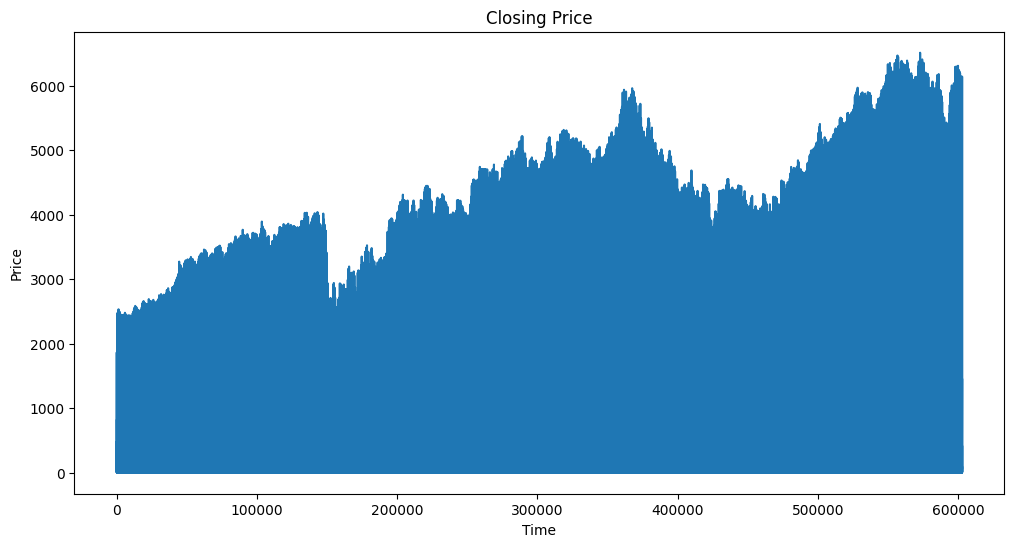

In [36]:
# Plotting the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Closing Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

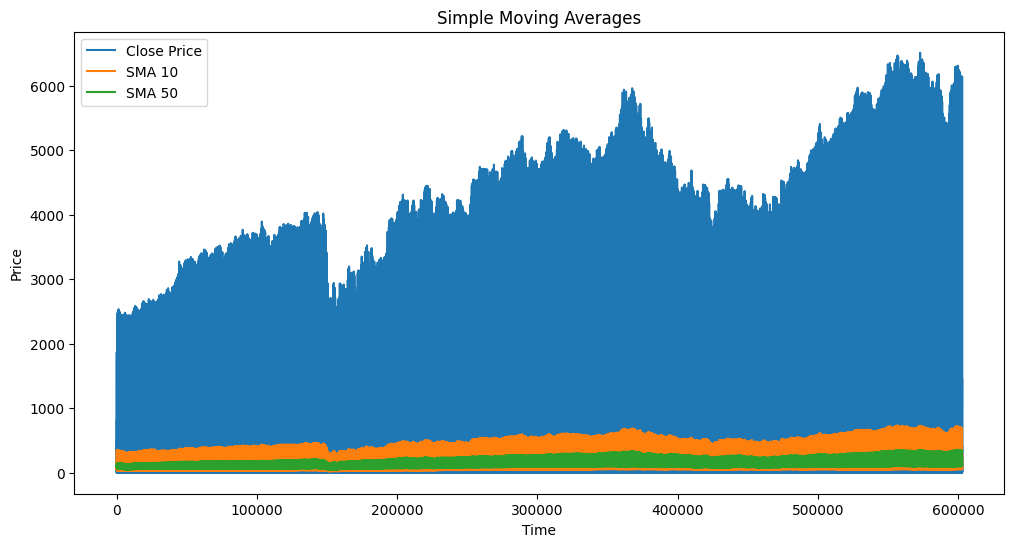

In [37]:
# Plotting SMA
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_10'], label='SMA 10')
plt.plot(df['SMA_50'], label='SMA 50')
plt.title('Simple Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

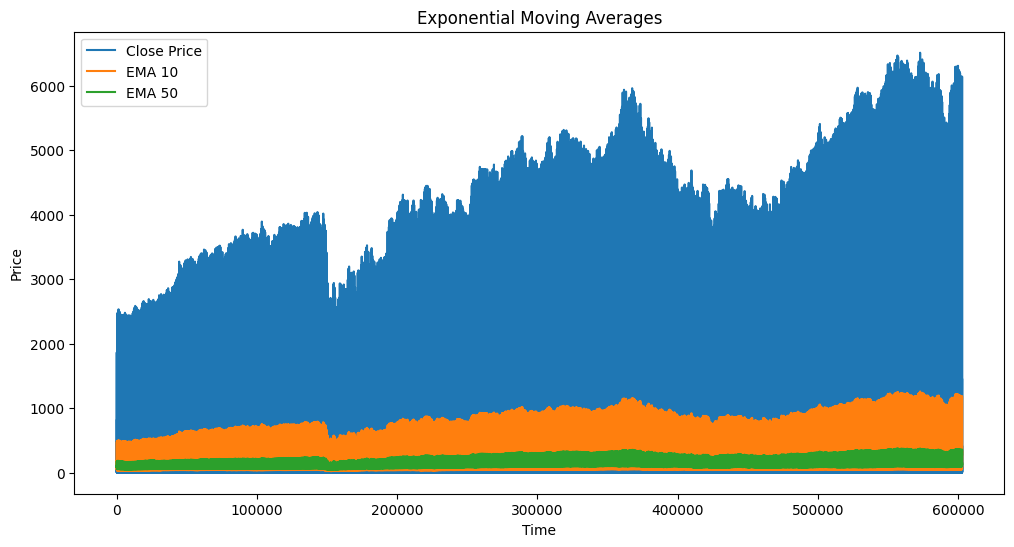

In [38]:
# Plotting EMA
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['EMA_10'], label='EMA 10')
plt.plot(df['EMA_50'], label='EMA 50')
plt.title('Exponential Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

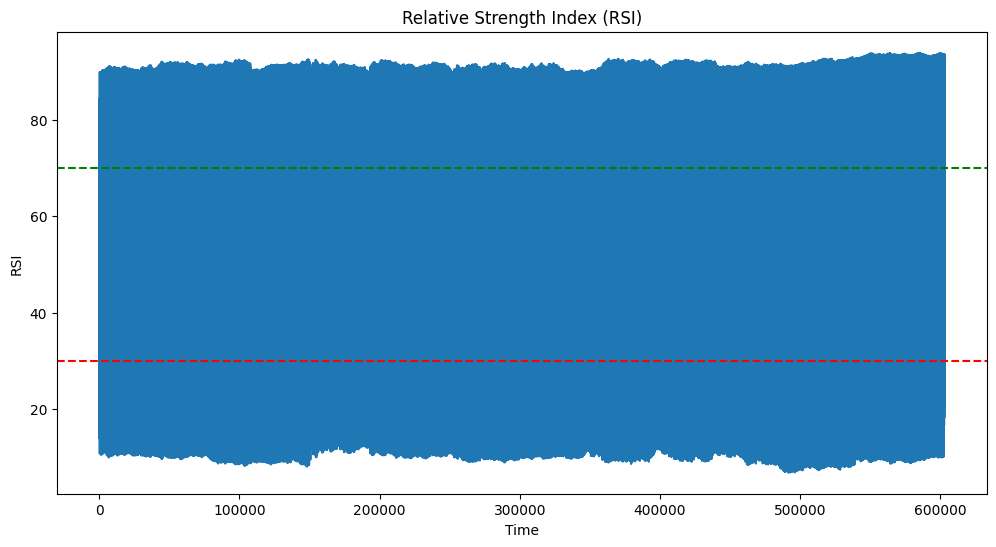

In [39]:
# Plotting RSI
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'])
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.axhline(y=30, color='r', linestyle='--')  # Oversold line
plt.axhline(y=70, color='g', linestyle='--')  # Overbought line
plt.show()

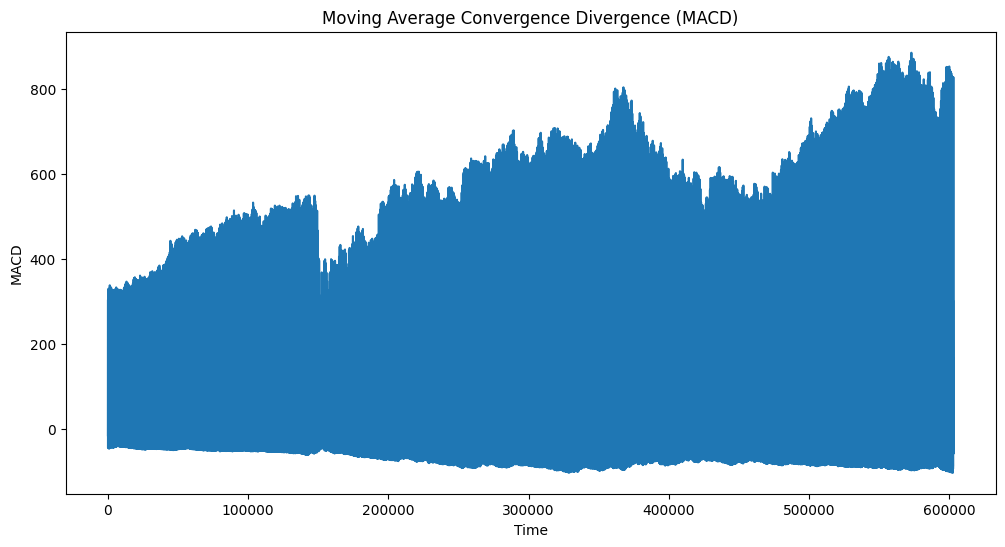

In [40]:
# Plotting MACD
plt.figure(figsize=(12, 6))
plt.plot(df['MACD'])
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Time')
plt.ylabel('MACD')
plt.show()

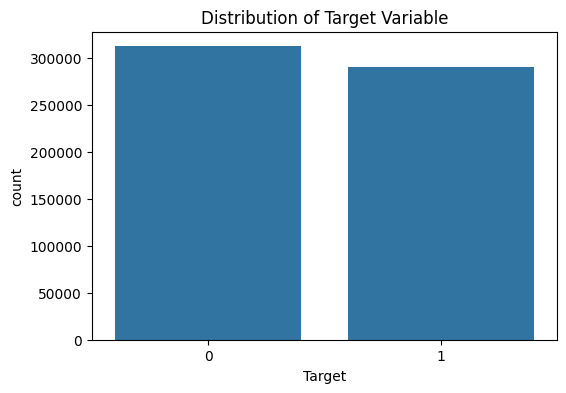

In [41]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable')
plt.show()

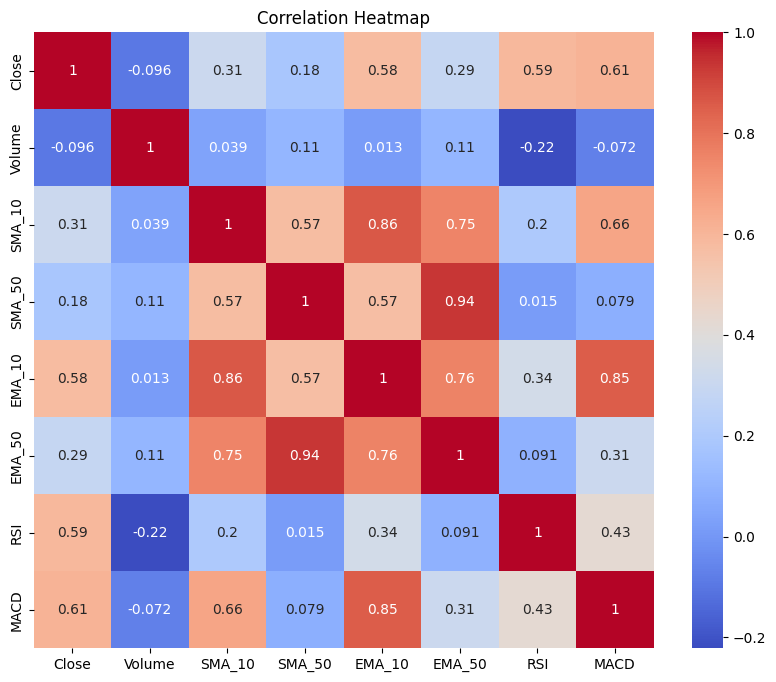

In [42]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Close', 'Volume', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'MACD']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

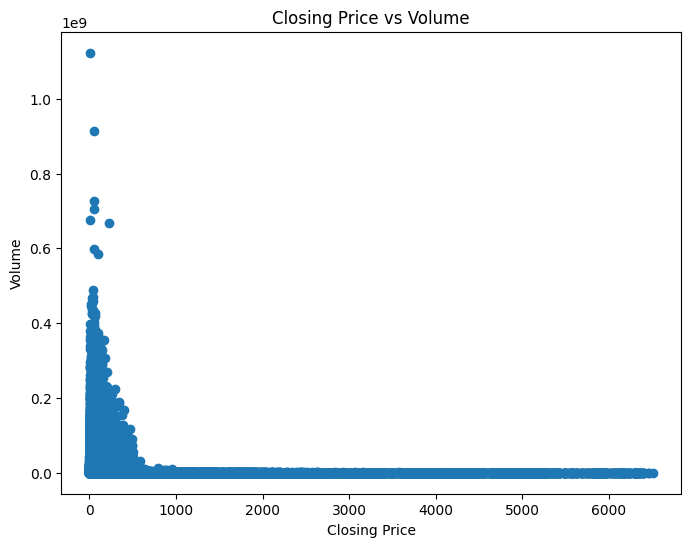

In [43]:
# Scatter plot of Closing Price vs Volume
plt.figure(figsize=(8,6))
plt.scatter(df['Close'],df['Volume'])
plt.xlabel("Closing Price")
plt.ylabel("Volume")
plt.title("Closing Price vs Volume")
plt.show()

<ipython-input-44-fdde5e33e9d9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Close'])
<ipython-input-44-fdde5e33e9d9>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Volume'])


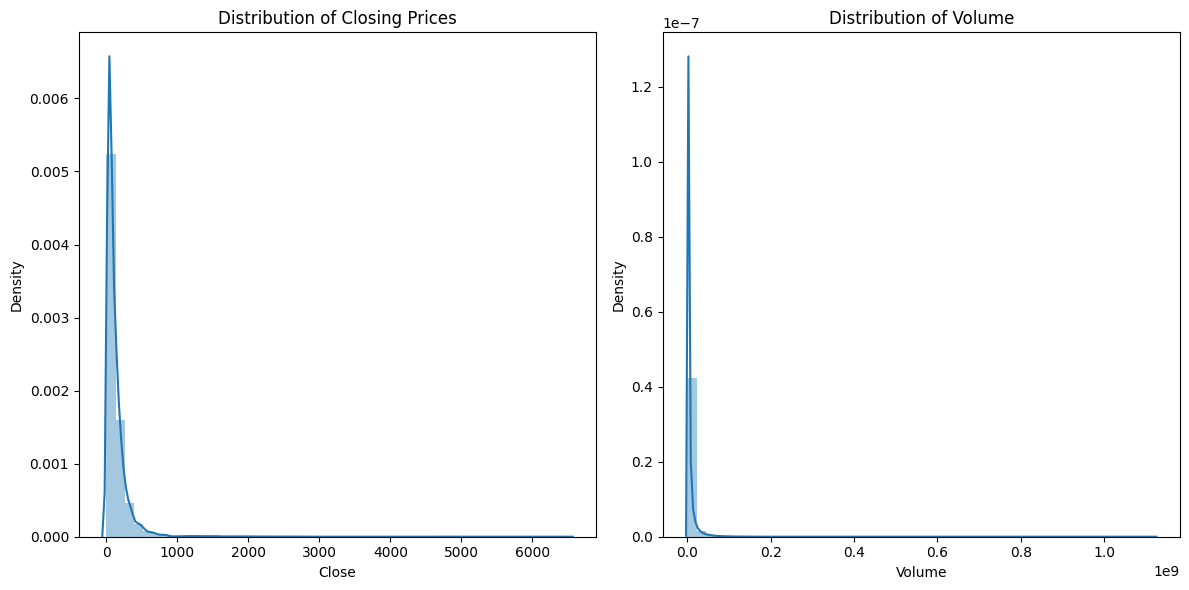

In [44]:
# Distribution plots of key features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(df['Close'])
plt.title('Distribution of Closing Prices')

plt.subplot(1, 2, 2)
sns.distplot(df['Volume'])
plt.title('Distribution of Volume')
plt.tight_layout()
plt.show()

## 🔄 **7. Data Preparation for Training**

### Selecting Features and Target

In [45]:
#Make a training dataset
Data= df[['Close', 'Open', 'High', 'Low', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'MACD','Target']]

In [46]:
#Separating The Feature and Target Variable
X = Data[['Close', 'Open', 'High', 'Low', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'MACD']]  # Features
y = Data["Target"]  # Target variable

# Now you can split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
#Normalizing Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 🔥 **8. Training LSTM Model**



In [ ]:
# Reshape the input data to be 3-dimensional
# [samples, timesteps, features]
if len(X_train.shape) != 3:
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

if len(X_test.shape) != 3:
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), # Use correct input shape
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.7392 - loss: 0.5171 - val_accuracy: 0.7600 - val_loss: 0.4856
Epoch 2/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 187s 6ms/step - accuracy: 0.7584 - loss: 0.4829 - val_accuracy: 0.7680 - val_loss: 0.4631
Epoch 3/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 207s 6ms/step - accuracy: 0.7641 - loss: 0.4673 - val_accuracy: 0.7835 - val_loss: 0.4390
Epoch 4/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - accuracy: 0.7753 - loss: 0.4484 - val_accuracy: 0.7989 - val_loss: 0.4114
Epoch 5/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step - accuracy: 0.7894 - loss: 0.4280 - val_accuracy: 0.8131 - val_loss: 0.3853
Epoch 6/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step - accuracy: 0.7985 - loss: 0.4103 - val_accuracy: 0.8236 - val_loss: 0.3686
Epoch 7/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - accuracy: 0.8075 - loss: 0.3955 - val_accuracy: 0.8331 - val_loss: 0.3537
Epoch 8/50
30146/30146 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - ac

###**Finding accuracy Of the model**

In [ ]:
# Evaluate Model Performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy: {accuracy * 100:.2f}%")

3769/3769 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9301 - loss: 0.1782
Neural Network Accuracy: 93.00%



## 📊 **10. Model Performance Visualization**

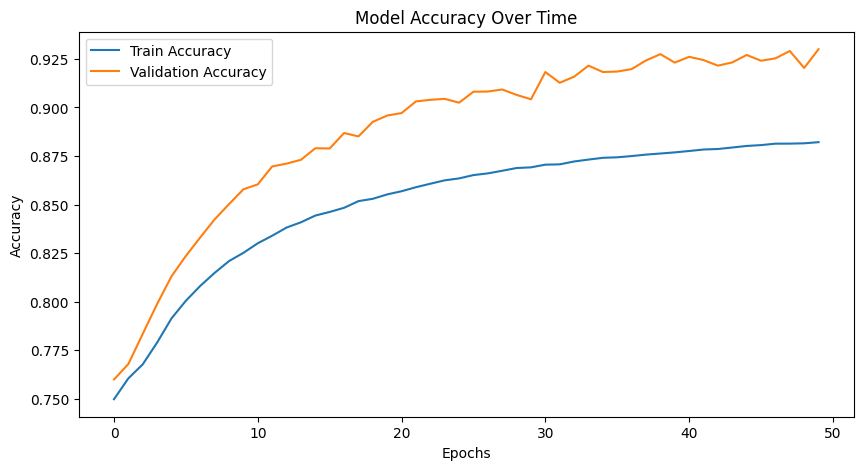

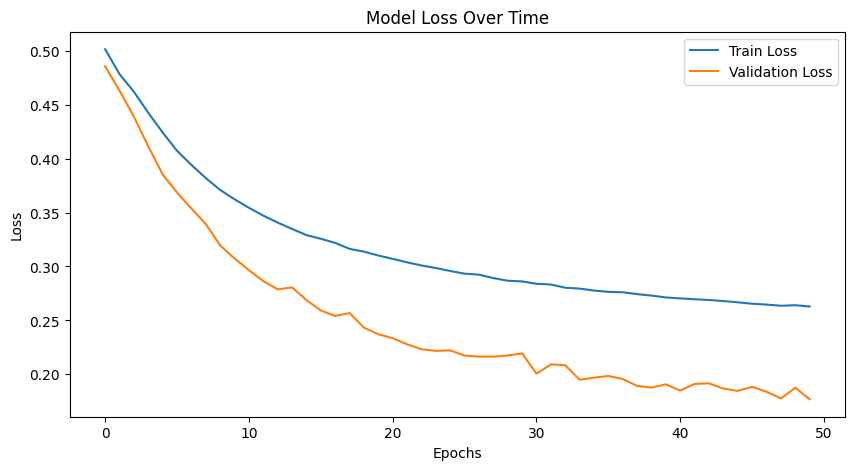

In [ ]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Time')
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Time')
plt.show()


## 🎯 **10. Saveing the Mode**

### Saving the model for future use in .H5 formate

In [ ]:
# Save the LSTM model
model.save("lstm_stock_model.h5")

print("LSTM model saved as 'lstm_stock_model.h5'")

LSTM model saved as 'lstm_stock_model.h5'
